# Pseudoproxy experiments with LMR and PAGES2k

In [25]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create a reconstruction job object

In [2]:
job = cfr.ReconJob(verbose=True)
print(job)

>>> job.configs:
{}


## Load a proxy database

The proxy database contains pseudoproxies generated from an iCESM simulation, with `SNR=10`, hence almost noiseless.

In [3]:
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
# the .plotly() method will generate an interactive map so that we are able to 
# check the proxy ID and location information of each site.
job.proxydb.plotly()

## Filter the proxy database

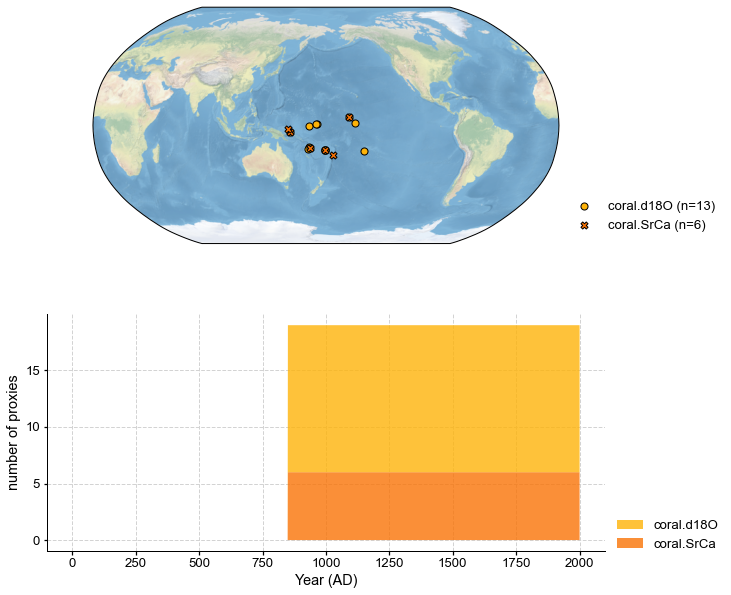

In [4]:
job.proxydb = job.proxydb.filter(by='loc-square', keys=(-20, 20, 150, 250))
# the .plot() method will generate a static map utilizing the Cartopy library
fig, ax = job.proxydb.plot(plot_count=True)

## Load climate model priors

In [5]:
job.load_clim(
    tag='prior',
    path_dict={
        # 'tas': './data/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
        'tas': './data/tas_CCSM4_cropped.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_CCSM4_cropped.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> The time axis does not overlap with the reference period (1951, 1980); use its own time period as reference [850.00, 1850.92].
>>> prior variables ['tas'] loaded
>>> job.prior created


In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


## Calibrate the PSMs

In [7]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
}
ptype_season_dict = {
    'coral.d18O': list(range(1, 13)),
    'coral.SrCa': list(range(1, 13)),
}
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    calib_period=(1750, 1850),
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'coral.d18O': 'Linear', 'coral.SrCa': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
>>> job.configs["psm_calib_period"] = (1750, 1850)


Calibrating the PSMs: 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]

>>> 19 records tagged "calibrated" with ProxyRecord.psm created


In [8]:
# check the fitting R-squared
print(job.proxydb.records['Ocn_098'].psm.calib_details['fitR2adj'])

# check the obs err matrix
print(job.proxydb.records['Ocn_098'].R)

0.9882226832051548
0.006051024278397452


## Forward the PSMs

In [9]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 19/19 [00:01<00:00, 11.40it/s]

>>> ProxyRecord.pseudo created for 19 records


## Annualize/seasonalize the climate model prior

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.prior updated


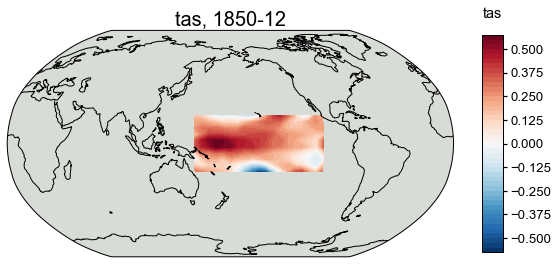

In [10]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
fig, ax = job.prior['tas'].plot(it=-1)

In [11]:
# job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
# job.prior['tas'].da

In [12]:
# job.crop_clim(tag='prior', lat_min=-20, lat_max=20, lon_min=150, lon_max=250, verbose=True)
# fig, ax = job.prior['tas'].plot(-1)

## Data assimilation

In [13]:
job.run_mc(save_dirpath='./results/ppe-pages2k', recon_seeds=[1, 2], verbose=True)

>>> job.configs["recon_period"] = [0, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./results/ppe-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 1}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 2001/2001 [00:07<00:00, 285.24it/s]


>>> Reconstructed fields saved to: ./results/ppe-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 2001/2001 [00:11<00:00, 177.91it/s]


>>> Reconstructed fields saved to: ./results/ppe-pages2k/job_r02_recon.nc
>>> DONE! Total time used: 0.34 mins.


## Validation

In [14]:
res = cfr.ReconRes('./results/ppe-pages2k', verbose=True)

>>> recon.paths:
['./results/ppe-pages2k/job_r01_recon.nc', './results/ppe-pages2k/job_r02_recon.nc']


In [24]:
res.load(['tas', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


In [27]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = [t.year for t in da.time.values]
ref_value = da.values
ref_name = 'truth'

(800.0, 2000.0)

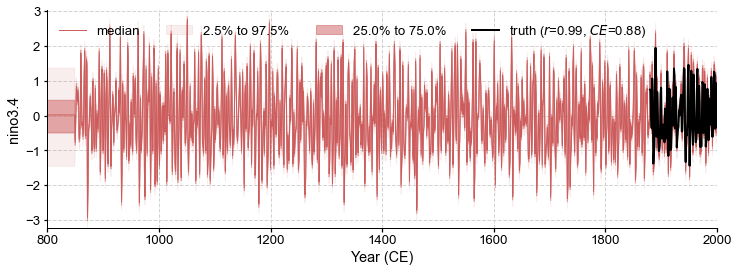

In [116]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(800, 2000)

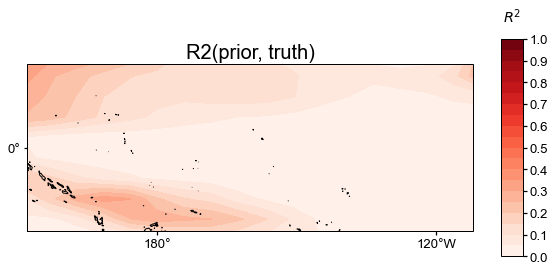

In [81]:
stat = 'R2'
valid_fd = job.prior['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    interp_direction='from-ref',
    valid_period=(1750, 1850),
)

fig, ax = valid_fd.plot(
    title=f'{stat}(prior, truth)',
    projection='PlateCarree',
    latlon_range=(-18, 18, 152, 248),
    **valid_fd.plot_kwargs)

In [92]:
job.proxydb.filter(by='tag', keys=['calibrated']).plotly()

In [113]:
lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 500

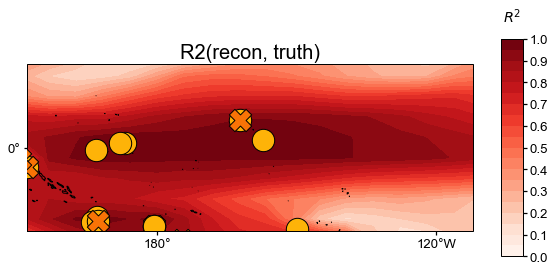

In [114]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    valid_period=(1750, 1850),
    interp_direction='from-ref',
    time_name='year',
)
fig, ax = valid_fd.plot(
    title=f'{stat}(recon, truth)',
    projection='PlateCarree',
    latlon_range=(-18, 18, 152, 248),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors,
    **valid_fd.plot_kwargs)